## Week 3 - Tuesday 2020-10-12

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/defreez/cs356-notebooks/blob/main/notebooks/week3-tue.ipynb)

In [ ]:
!pip install -Uqq fastbook
import fastbook
from fastbook import *
fastbook.setup_book()

from fastai.vision.widgets import *

## Chapter 2 stuff

- Bing image search
- Useful if you want to grab some images to test an image classification idea
    - Also useful exercise in data cleaning

## Searching Azure

- Here is an API key you can use. Please don't abuse it so we can keep having nice things.

In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY', '87106c462b7f47f4ae24e13ff802d458')

In [ ]:
results = search_images_bing(key, 'grizzly bear')

In [ ]:
!rm -rf bears

In [ ]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

path.mkdir()
for o in bear_types:
    print(o)
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{o} bear', max_images=50)
    download_images(dest, urls=results.attrgot('contentUrl'))

In [ ]:
fns = get_image_files(path)

In [ ]:
failed = verify_images(fns)
failed

In [ ]:
failed.map(Path.unlink)

In [ ]:
bears = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(128)])

In [ ]:
dls = bears.dataloaders(path)

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(2)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()

In [ ]:
for idx,cat in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
str(gdrive)

In [ ]:
!zip -r '/content/gdrive/My Drive/bears.zip' bears

In [ ]:
path = untar_data(URLs.MNIST)

# In-class Exercise

- Change the image search query
- Clean the data
- Save your dataset

# MNIST all digits without ResNet

In [ ]:
path.ls()

In [ ]:
train_images = get_image_files(path/'training')
train_x_list = [tensor(Image.open(img_path)).cuda() for img_path in train_images]
train_y_list = [int(img_path.parent.name) for img_path in train_images]
train_x = ((torch.stack(train_x_list)).float()/255).view(-1, 28 * 28)
train_y = tensor(train_y_list).cuda().view(-1, 1)

train_x.shape, train_y.shape

In [ ]:
train_dset = list(zip(train_x, train_y))

In [ ]:
valid_images = get_image_files(path/'testing')
valid_x_list = [tensor(Image.open(img_path)).cuda() for img_path in valid_images]
valid_y_list = [int(img_path.parent.name) for img_path in valid_images_list]
valid_x = (torch.stack(valid_x_list).float()/255).view(-1, 28*28)
valid_y = tensor(valid_y_list).cuda().view(-1,1)

valid_x.shape, valid_y.shape

In [ ]:
valid_dset = list(zip(valid_x, valid_y))

In [ ]:
train_dl = DataLoader(train_dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)

# Dealing with multiple classes


## Softmax

- Think of it as sigmoid but with multiple classes
- Sum of softmax classes will add up to 1
- One activation for each category 

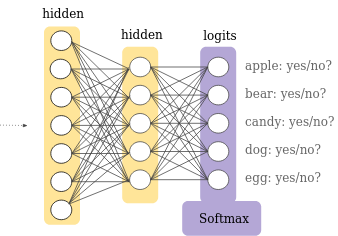

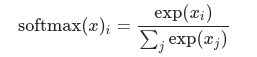

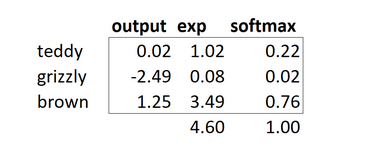

## Log softmax

- We take the log of the softmax activaiton for a variety of reasons
- Numerically stable
  - Gets rid of very small numbers
- Removes "gray area", more likely to definitively pick a class. This is usually what we want, not always.

## Negative Log Likelihood

- Select the activation that corresponds to the class
- If we predict class 3, take class 3. If we predict class 4, take class 4.
- Turns activation into something we can minimize, smaller is better
- The books description is wrong here because they describe this process before taking the log and call it the loss.
  It isn't!
- Taking the log of a number between 0 and 1 is negative. 
- Therefore we need the negative log

## Cross Entropy Loss

1. Softmax
2. Take log of softmax for each category
3. Choose category column corresponding to index of category
4. Multiply by -1

In [ ]:
def mnist_loss(pred, actual):
    l = nn.CrossEntropyLoss()
    return l(pred, actual.squeeze())

In [ ]:
def calc_grad(xb, yb, model):
    pred = model(xb)
    loss = mnist_loss(pred, yb)
    loss.backward()
    return loss

In [ ]:
def batch_accuracy(pred, actual):
    digit_pred = pred.max(dim=1)[1]
    return (digit_pred == actual.squeeze()).float().mean()

In [ ]:
# Global opt is stupid
def train_epoch(model, optimizer):
    batch_loss = []
    for xb, yb in train_dl:
        batch_loss.append(calc_grad(xb, yb, model))
        optimizer.step()
        optimizer.zero_grad()
    return tensor(batch_loss).mean()

In [ ]:
class BasicOptim:
    def __init__(self, params, lr): 
        self.params, self.lr = list(params), lr
    
    def step(self):
        for p in self.params:
            p.data -= p.grad.data * self.lr
            
    def zero_grad(self):
        for p in self.params:
            p.grad = None

## Our neural network

- The architecture is somewhat arbitrary at this point
- We don't yet have any guiding principles for how to construct this
- Soon we'll see one particularly useful layer we can add - convolutions

In [ ]:
simple_net = nn.Sequential(
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 30),
    nn.ReLU(),
    nn.Linear(30, 10)
).cuda()

In [ ]:
batch_accuracy(simple_net(valid_x), valid_y)

In [ ]:
o = BasicOptim(simple_net.parameters(), lr=0.1)

In [ ]:
def train_model(model, epochs, opt):
    for i in range(epochs):
        avg_bl = train_epoch(model, opt)
        print(i, avg_bl.item(), batch_accuracy(model(valid_x), valid_y).item())

In [ ]:
%%time
train_model(simple_net, 32, o)

## In practice

- Cross entropy loss should be the default loss function for multi-class problems
- We can choose other loss functions
    - E.g. Focal loss helps with class imbalance

# Next up: DeepRacer teaser